In [1]:
from operator import attrgetter

import numpy as np
import pandas as pd
import seaborn as sns
import shapely.geometry as sh
from matplotlib import pyplot as plt

from libsimplesn import SimpleSN


sns.reset_orig()

simplesn = SimpleSN('pantheon-g10')


VERSIONS = {
    (1_000, 'mphotoz'): 0, (1_000, 'specz'): 0, (1_000, 'photoz'): 0,
    (2_000, 'mphotoz'): 0, (2_000, 'specz'): 0, (2_000, 'photoz'): 0,
    (5_000, 'mphotoz'): 0, (5_000, 'specz'): 0, (5_000, 'photoz'): 0,
    (10_000, 'mphotoz'): 0, (10_000, 'specz'): 2, (10_000, 'photoz'): 0,
    (20_000, 'mphotoz'): 0, (20_000, 'specz'): 0, (20_000, 'photoz'): 0,
    (50_000, 'mphotoz'): 0, (50_000, 'specz'): 0, (50_000, 'photoz'): 0,
    (100_000, 'mphotoz'): 1, (100_000, 'specz'): 2, (100_000, 'photoz'): 0,
}

In [ ]:
LEVELS = (0.1, 0.5, 0.68, 0.9, 0.95)

res = {
    (t,) + key[:4] + (level,): sh.MultiPolygon([(c, []) for c in cs])
    for t, hdis in (('mcmc', simplesn.hdi_mc), ('nre', simplesn.hdi_nre))
    for key, xyz in hdis.items() if t == 'mcmc' or key[-1].endswith(f'version_{VERSIONS[key[:2]]}')
    for level, cs in zip(LEVELS, plt.tricontour(*xyz, levels=LEVELS).allsegs)
}
plt.close()

area = pd.Series(res.values(), index=pd.MultiIndex.from_tuples(
    res.keys(), names=('method', 'N', 'datatype', 'suffix', 'version', 'level')
), name='poly').apply(attrgetter('area')).rename('area').xs(0, level='suffix').sort_index()
area

In [14]:
dta = area.reset_index().groupby([n for n in area.index.names if n not in ('version',)])['area'].aggregate([np.mean, np.std])
dta = pd.concat({
    'mcmc': dta.loc['mcmc'], 'nre': dta.loc['nre'],
    'ratio': (area['nre'] / area['mcmc']).reset_index().groupby([n for n in area.index.names if n not in ('version', 'method')])['area'].aggregate([np.mean, np.std])
}, axis='columns')
dta.columns = dta.columns.to_flat_index()
dta = dta.rename(columns=' '.join)
dta.to_csv('paper/plotdata/areas.csv')
dta

mcmc mean      mcmc std  nre mean       nre std  \
N      datatype level                                                    
1000   mphotoz  0.10    0.007574  1.174892e-03  0.010985  1.912736e-03   
                0.50    0.051800  7.279373e-03  0.070552  9.027404e-03   
                0.68    0.084703  1.181290e-02  0.111244  1.129695e-02   
                0.90    0.163368  2.042365e-02  0.200023  1.567700e-02   
                0.95    0.203872  2.486401e-02  0.243233  2.387163e-02   
...                          ...           ...       ...           ...   
100000 specz    0.10    0.000013  9.268114e-07  0.000018  4.699627e-07   
                0.50    0.000086  4.640921e-06  0.000116  3.123820e-06   
                0.68    0.000142  7.374892e-06  0.000187  4.669619e-06   
                0.90    0.000285  1.034701e-05  0.000372  8.245528e-06   
                0.95    0.000371  1.082153e-05  0.000486  9.698571e-06   

                       ratio mean  ratio std  
N      datatype level                         
1000   mphotoz  0.10     1.451618   0.133890  
                0.50     1.368304   0.110405  
                0.68     1.323916   0.119006  
                0.90     1.236047   0.137302  
                0.95     1.200760   0.119535  
...                           ...        ...  
100000 specz    0.10     1.401736   0.115864  
                0.50     1.349463   0.091672  
                0.68     1.317945   0.083838  
                0.90     1.303409   0.060726  
                0.95     1.311093   0.052123  

[70 rows x 6 columns]

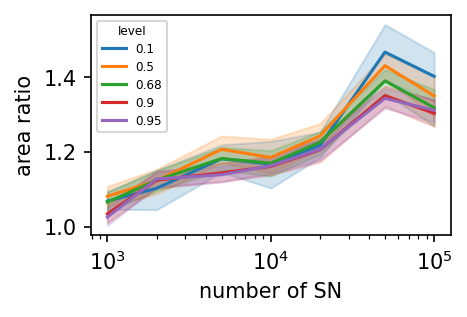

In [19]:
dta = area['nre'] / area['mcmc']
dta = dta[dta.index.get_level_values('datatype') == 'specz']
plt.figure(figsize=(3, 2))
ax = sns.lineplot(
    data=dta.rename('ratio').reset_index(), x='N', y='ratio',
    hue='level', palette='tab10'
)
ax.set_xscale('log')
ax.set_xlabel('number of SN')
ax.set_ylabel('area ratio')
ax.get_legend().remove()
ax.legend(title='level', fontsize='xx-small', title_fontsize='xx-small')

/usr/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


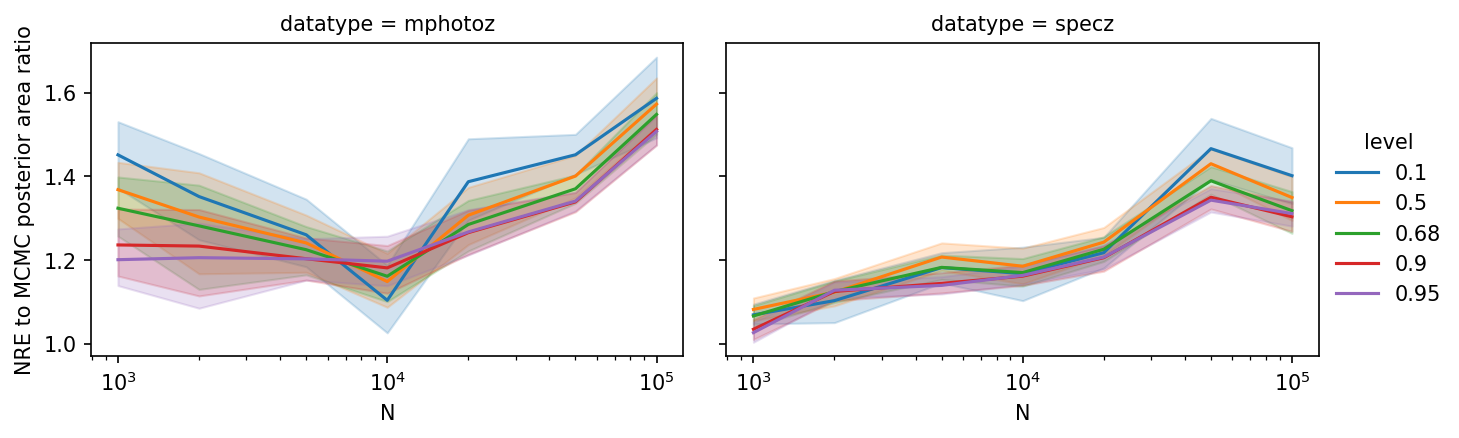

In [12]:
sns.relplot(
    data=(area['nre'] / area['mcmc']).rename('ratio').reset_index(), x='N', y='ratio',
    hue='level', col='datatype',
    palette='tab10',
    kind='line', height=3, aspect=1.5, facet_kws=dict(despine=False)
).set(xscale='log', ylabel='NRE to MCMC posterior area ratio');

In [4]:
area[np.logical_and(
        area.index.get_level_values('level') == 0.68,
        area.index.get_level_values('datatype') == 'mphotoz'
    )]

method  N       datatype  version  level
mcmc    1000    mphotoz   0        0.68     0.094208
                          1        0.68     0.078612
                          2        0.68     0.083575
                          3        0.68     0.078133
                          4        0.68     0.099762
                                              ...   
nre     100000  mphotoz   5        0.68     0.001414
                          6        0.68     0.001416
                          7        0.68     0.001476
                          8        0.68     0.001421
                          9        0.68     0.001488
Name: area, Length: 140, dtype: float64

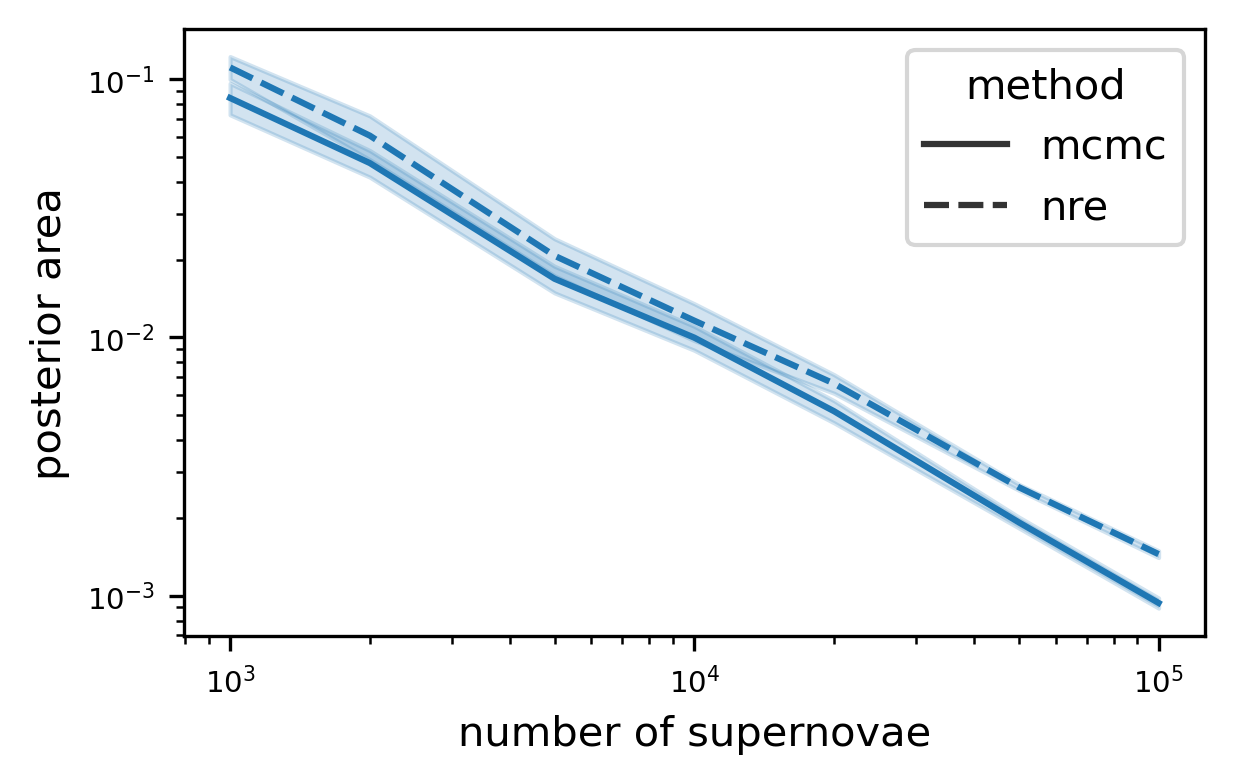

In [15]:
plt.figure(figsize=(4, 2.5), dpi=300)
ax = sns.lineplot(
    data=area[np.logical_and(
        area.index.get_level_values('level') == 0.68,
        area.index.get_level_values('datatype') == 'mphotoz'
    )].reset_index(), x='N', y='area',
    style='method',
    ci='sd',
)
ax.set(xscale='log', yscale='log', xlabel='number of supernovae', ylabel='posterior area')
ax.tick_params(labelsize=7)

/usr/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


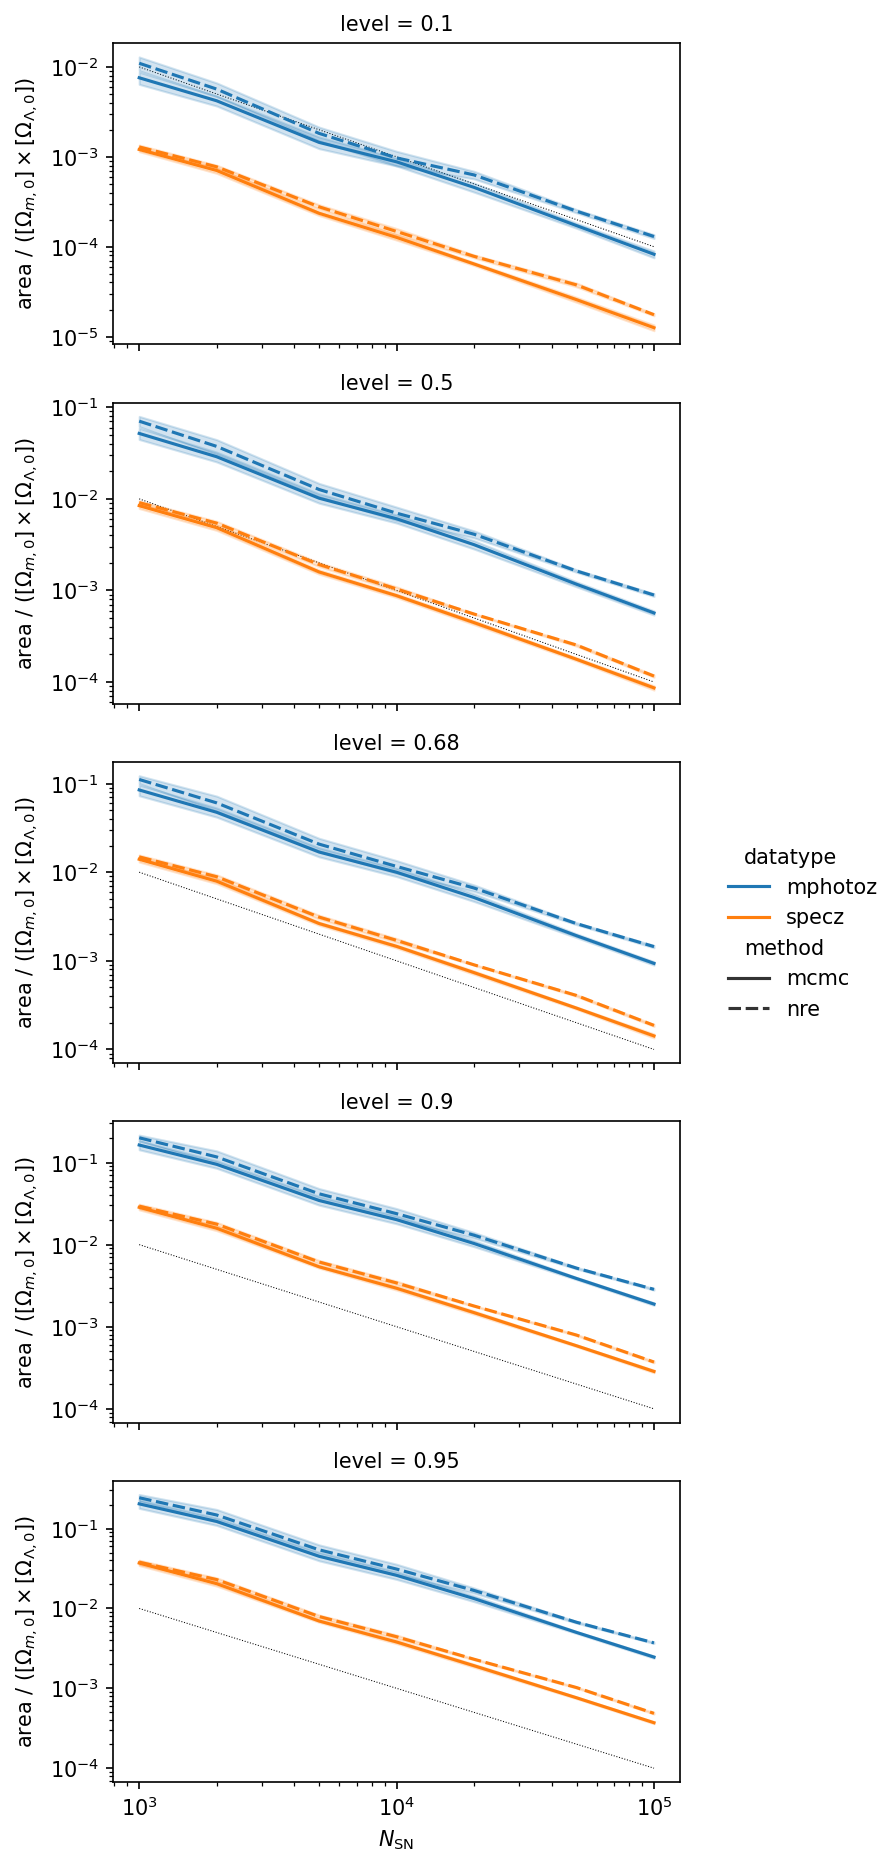

In [11]:
def annotate(data, **kwargs):
    plt.plot((1e3, 1e5), (1e-2, 1e-2 * ((1e5/1e3)**(-0.5))**2), 'k:', lw=0.5, zorder=-1)


g = sns.relplot(
    data=area.reset_index(), x='N', y='area',
    hue='datatype', style='method', row='level',
    kind='line', ci='sd',
    height=2.5, aspect=2, facet_kws=dict(sharey='row', despine=False),
).map_dataframe(annotate).set(yscale='log', xscale='log').set_axis_labels('$N_{\mathrm{SN}}$', r'area / $([\Omega_{m, 0}] \times [\Omega_{\Lambda, 0}])$');